```
• Implement Clustering: Use algorithms like Kmeans to detect natural
clusters in the Twitter data.
• Classify Sentiments: Apply SVM and RNN for unsupervised sentiment
classification.
• Performance Metrics: Evaluate models based on accuracy, precision,
recall, and F1 score.
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import tensorflow

In [2]:
file_name = os.path.join(os.getcwd(),  'sentiment_analysis.csv')
df = pd.read_csv(file_name)
df = df.drop(columns=['id'])
df.head()

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...


In [3]:
def clean(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    # text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\n',' ', text)  # Remove line breaks
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove punctuation
    text = text.lower()  # Lowercase

    filtered_text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

    return filtered_text

# Function to extract hashtags from a tweet
def extract_hashtags(tweet):
    hashtags = re.findall(r'#(\w+)', tweet)
    return hashtags

# Apply the function to extract hashtags and create a new column
df['hashtags'] = df['tweet'].apply(extract_hashtags)

df['cleaned_tweet'] = df['tweet'].apply(clean)

In [4]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['cleaned_tweet'])

# Applying K-means clustering
k = 5  # Number of clusters
model = KMeans(n_clusters=k, random_state=42)
model.fit(X)

# Assigning cluster labels to the data points
df['cluster'] = model.labels_

# Analyze cluster centroids (to find top terms per cluster)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {top_terms}")

# View the data with clusters
print(df[['tweet', 'cluster']].head())

Cluster 0: ['health', 'fail', 'tech', 'fashion', 'funny', 'news', 'lol', 'photography', 'ipad', 'iphone']
Cluster 1: ['samsung', 'galaxy', 'new', 'phone', 'note', 'android', 'instagram', 'fun', 'galaxys', 'finally']
Cluster 2: ['sony', 'ps', 'new', 'playstation', 'xperia', 'camera', 'game', 'photography', 'gamer', 'gaming']
Cluster 3: ['iphone', 'apple', 'phone', 'new', 'ipad', 'just', 'ios', 'like', 'love', 'day']
Cluster 4: ['follow', 'gain', 'rt', 'sougofollow', 'rts', 'followers', 'iphone', 'followback', 'retweet', 'followsunday']
                                               tweet  cluster
0  #fingerprint #Pregnancy Test https://goo.gl/h1...        3
1  Finally a transparant silicon case ^^ Thanks t...        2
2  We love this! Would you go? #talk #makememorie...        3
3  I'm wired I know I'm George I was made that wa...        3
4  What amazing service! Apple won't even talk to...        3


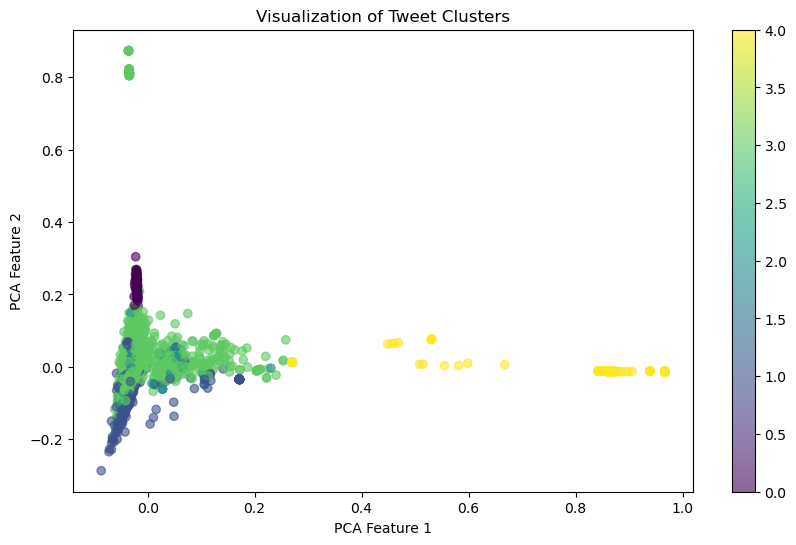

In [5]:
# Visualization of Clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X.toarray())

# Scatter plot of the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.title('Visualization of Tweet Clusters')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(scatter)
plt.show()

In [6]:
# Performance Metrics: Evaluate models based on accuracy, precision, recall, and F1 score.
performance_data = {}

In [8]:
# SVM Based approach:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_fscore_support
import pandas as pd

# Dictionary to hold performance data for each cluster
cluster_performance_data = {}

# Iterate over each cluster
for cluster_id in range(5):  # Adjust based on your number of clusters
    print(f"Processing Cluster {cluster_id}")
    # Filter data for the current cluster
    cluster_data = df[df['cluster'] == cluster_id]
    
    # Split the dataset into training, validation, and testing sets within the cluster
    train_df, test_df = train_test_split(cluster_data, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

    # Check if training data has at least two classes
    if len(train_df['label'].unique()) < 2:
        print(f"Skipping Cluster {cluster_id} due to insufficient class variety.")
        continue

    # Feature extraction
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
    X_train = tfidf_vectorizer.fit_transform(train_df['tweet'])
    y_train = train_df['label']
    X_val = tfidf_vectorizer.transform(val_df['tweet'])
    y_val = val_df['label']
    X_test = tfidf_vectorizer.transform(test_df['tweet'])
    y_test = test_df['label']

    # Train the SVM model
    svm_model = SVC(kernel='linear', random_state=42)  # You can try different kernels and hyperparameters
    svm_model.fit(X_train, y_train)

    # Validate the model
    y_val_pred = svm_model.predict(X_val)
    val_accuracy = (y_val_pred == y_val).mean()
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')

    # Test the model
    y_test_pred = svm_model.predict(X_test)
    test_accuracy = (y_test_pred == y_test).mean()
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')

    # Store performance data
    cluster_performance_data[cluster_id] = {
        'Validation': [val_accuracy, val_precision, val_recall, val_f1],
        'Testing': [test_accuracy, test_precision, test_recall, test_f1]
    }

# Print out performance data for each cluster
for cluster_id, performance in cluster_performance_data.items():
    print(f"Cluster {cluster_id} Performance:")
    print(f"Validation - Accuracy: {performance['Validation'][0]}, Precision: {performance['Validation'][1]}, Recall: {performance['Validation'][2]}, F1 Score: {performance['Validation'][3]}")
    print(f"Testing - Accuracy: {performance['Testing'][0]}, Precision: {performance['Testing'][1]}, Recall: {performance['Testing'][2]}, F1 Score: {performance['Testing'][3]}")



Processing Cluster 0
Processing Cluster 1
Processing Cluster 2
Processing Cluster 3


c:\Users\brite\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\brite\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\brite\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\brite\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: Und

Processing Cluster 4
Skipping Cluster 4 due to insufficient class variety.
Cluster 0 Performance:
Validation - Accuracy: 1.0, Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Testing - Accuracy: 1.0, Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Cluster 1 Performance:
Validation - Accuracy: 0.967741935483871, Precision: 1.0, Recall: 0.5555555555555556, F1 Score: 0.7142857142857143
Testing - Accuracy: 0.968, Precision: 0.5, Recall: 0.25, F1 Score: 0.3333333333333333
Cluster 2 Performance:
Validation - Accuracy: 0.935064935064935, Precision: 0.5, Recall: 0.2, F1 Score: 0.28571428571428575
Testing - Accuracy: 0.948051948051948, Precision: 0.6666666666666666, Recall: 0.4, F1 Score: 0.5
Cluster 3 Performance:
Validation - Accuracy: 0.8770053475935828, Precision: 0.7864077669902912, Recall: 0.8663101604278075, F1 Score: 0.8244274809160305
Testing - Accuracy: 0.8629893238434164, Precision: 0.7867298578199052, Recall: 0.8383838383838383, F1 Score: 0.8117359413202934


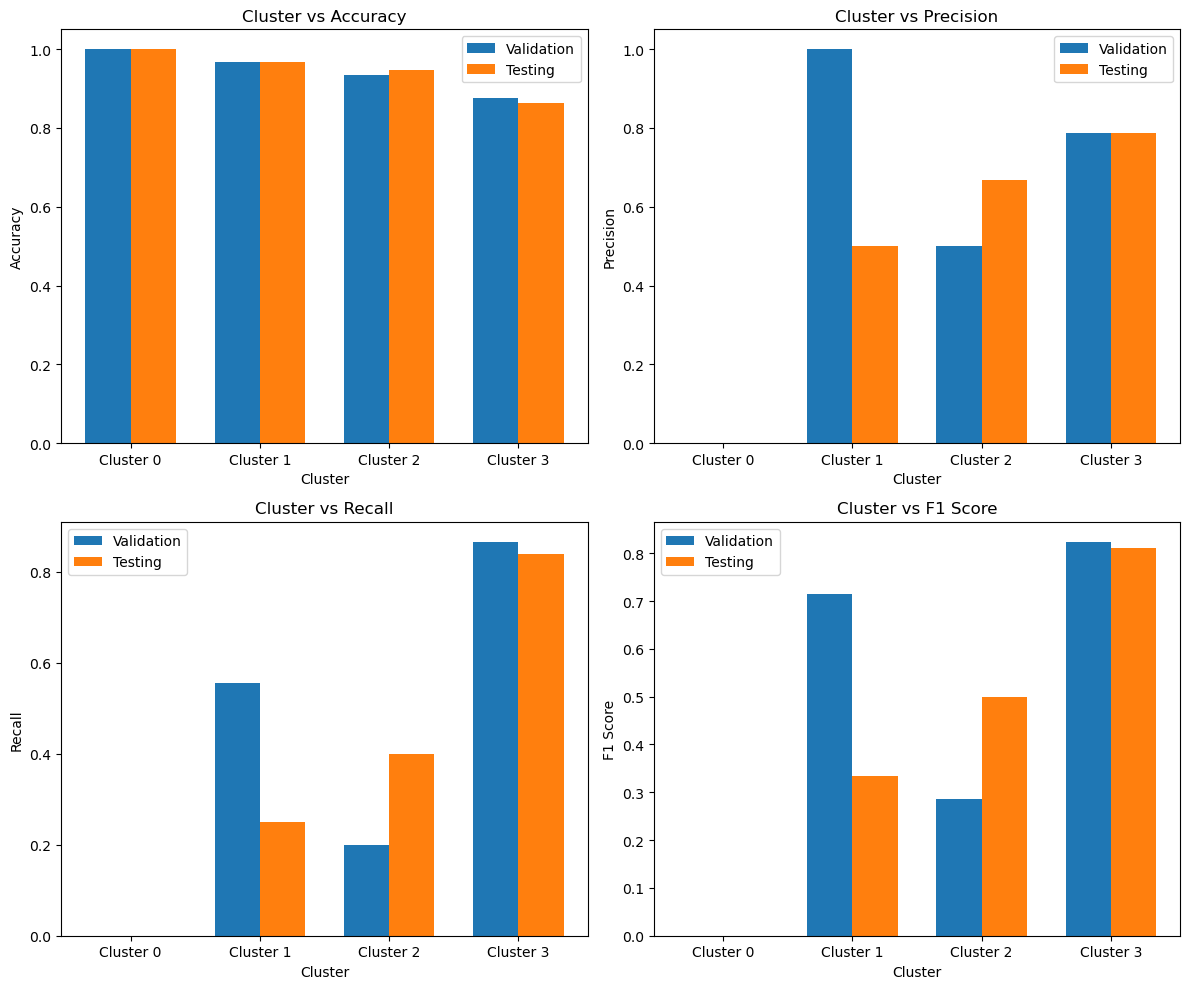

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming cluster_performance_data is structured as {cluster_id: {'Validation': [acc, prec, rec, f1], 'Testing': [acc, prec, rec, f1]}}
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
clusters = list(cluster_performance_data.keys())
n_clusters = len(clusters)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for i, metric in enumerate(metrics):
    validation_scores = [cluster_performance_data[cluster]['Validation'][i] for cluster in clusters]
    testing_scores = [cluster_performance_data[cluster]['Testing'][i] for cluster in clusters]
    
    bar_width = 0.35
    index = np.arange(n_clusters)
    
    axs[i].bar(index, validation_scores, bar_width, label='Validation')
    axs[i].bar(index + bar_width, testing_scores, bar_width, label='Testing')
    
    axs[i].set_xlabel('Cluster')
    axs[i].set_ylabel(metric)
    axs[i].set_title(f'Cluster vs {metric}')
    axs[i].set_xticks(index + bar_width / 2)
    axs[i].set_xticklabels(['Cluster ' + str(cluster) for cluster in clusters])
    axs[i].legend()

plt.tight_layout()
plt.show()


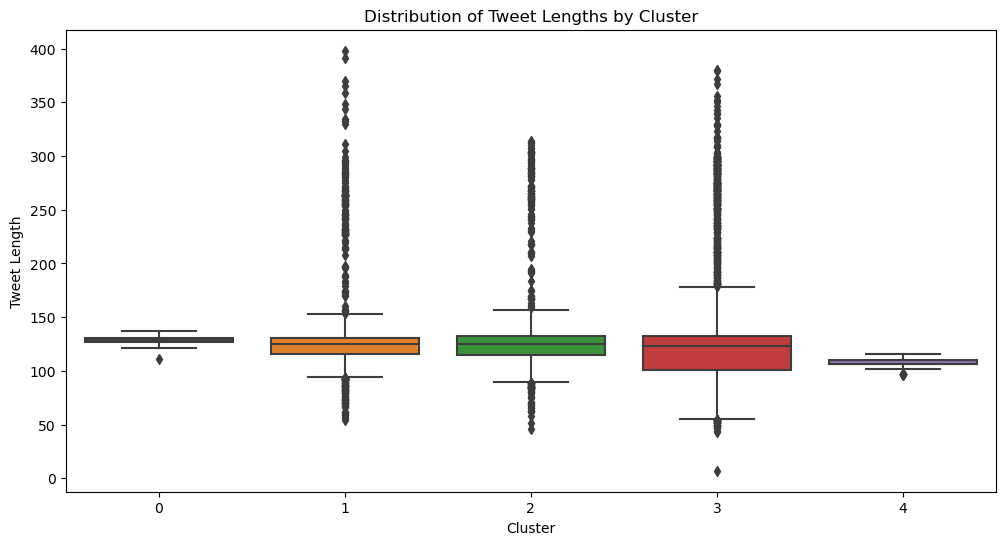

In [11]:
# Calculate tweet lengths and visualize
df['tweet_length'] = df['tweet'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='tweet_length', data=df)
plt.title('Distribution of Tweet Lengths by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Tweet Length')
plt.show()